In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

from helper_funcs import load_energy_data, load_temperature, merge_datasets, resample_as_needed

#Prophet version is 0.7.1 at the time of writing
from fbprophet import Prophet 
from fbprophet.plot import plot_plotly, plot_components_plotly

Importing plotly failed. Interactive plots will not work.


## Prophet by Facebook

Directly from the docs:

"Prophet is a procedure for forecasting time series data based on an **additive model** where non-linear trends are fit with **yearly, weekly, and daily seasonality, plus holiday effects**. 
It works best with time series that have **strong seasonal effects and several seasons of historical data**. 
Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.1"

Link to the documentation: https://facebook.github.io/prophet/docs/quick_start.html
We have found the maintainers to be very active on github and strongly recommend reading through relevant issues. Frequently they contain useful best practices.

### Installing Prophet

Prophet's engine is **Stan**-based and it relies on pystan to run. When installing, it is important to make sure pystan has compiled well. 

For Conda environment, we have found the following sequence to work well:

1. First install Ephem (helps with pystan compilation):
conda install -c anaconda ephem
2. Install Pystan:
conda install -c conda-forge pystan
3. Finally install Fbprophet
conda install -c conda-forge fbprophet

When you are running a Jupyter Notebook or JupyterLab, if you run into "fbprophet not found" errors, make sure you have jupyter notebook installed in your environment. You can do so by running *conda install -c anaconda notebook*.


## Data Load

Prophet expects the data in a particular format:
- The data needs to be in a pandas DataFrame with column "ds" containing the time component and column "y" containing the target variable.
- Any additional variables of interest can be added as a separate column. One needs to make sure to add them to both the train data and the DataFrame used to produce the forecast.

In [7]:
# Data Load
energy = load_energy_data("../data/") # Load the energy consumption data
temp = load_temperature('../data/avg_temp.csv') # Load the temperature data
final_df = merge_datasets(energy, temp)
print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52614 entries, 0 to 52613
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      52614 non-null  datetime64[ns]
 1   actuals   52546 non-null  float64       
 2   avg_temp  52614 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.6 MB
None
                 time  actuals  avg_temp
0 2015-01-01 00:00:00   5024.0      -9.7
1 2015-01-01 01:00:00   4773.0      -9.7
2 2015-01-01 02:00:00   4585.0      -9.7
3 2015-01-01 03:00:00   4440.0      -9.7
4 2015-01-01 04:00:00   4418.0      -9.7


The data used represents hourly energy consumption in Bulgaria and daily temperature in Sofia.

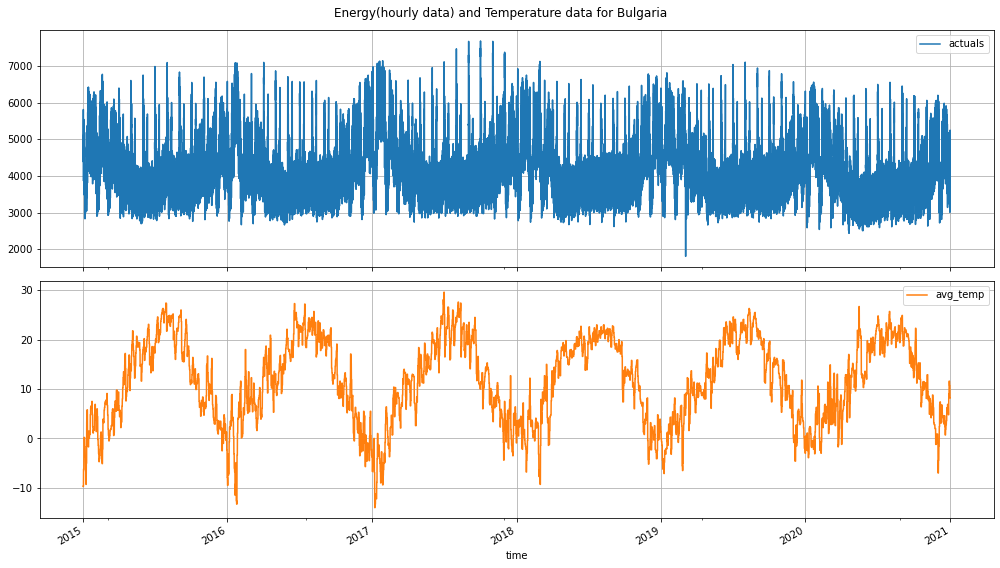

In [22]:
(final_df.
 set_index('time').
 plot(subplots=True, figsize=(14,8), grid=True))

plt.suptitle('Energy(hourly data) and Temperature data for Bulgaria')
plt.tight_layout()
plt.show()

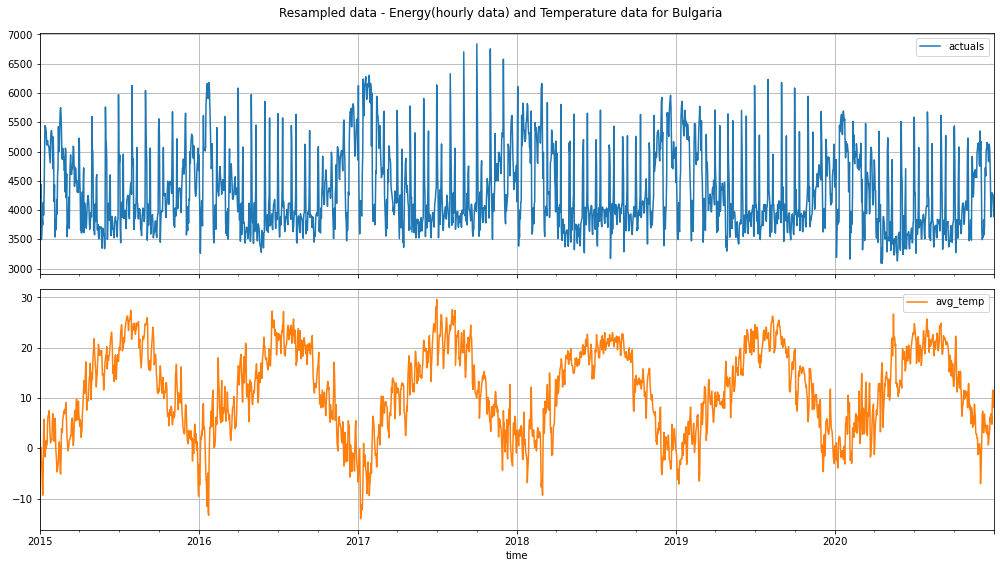

In [24]:
(final_df.
 pipe(resample_as_needed).
 plot(subplots=True, figsize=(14,8), grid=True))

plt.suptitle('Resampled data - Energy(hourly data) and Temperature data for Bulgaria')
plt.tight_layout()
plt.show()

Let us prepare the data in the Prophet format

In [25]:
prophet_time_series = final_df.copy()

## Renaming so that the format fits Prophet's requirements
prophet_time_series = prophet_time_series.rename({'time':'ds', 'actuals':'y'}, axis=1)

train_set_prophet = prophet_time_series.loc[lambda df: df['ds']< pd.to_datetime('2020-01-01')]
test_set_prophet = prophet_time_series.loc[lambda df: df['ds']>= pd.to_datetime('2020-01-01')]

### Modelling

Prophet follows a scikit-learn like API. A Model object is created and data is fitted. 
Then, a future DataFrame is created - just a pandas DataFrame containing one column "ds" and the future periods. 
Lastly, the fitted model object is used to predict and predictions are stored in a forecast object.

Important note - the forecast dataframe stores by default in the yhat column both the forecast and the fitted yhat. However, the fitted yhat is not equal the train data - it is just the fit of it.

The forecast dataframe contains a number of useful details:
- Lower and Upper Confidence Intervals
- Breakdown of components - trend, seasonal effects
- The effect of any holidays or additional regressors added to the model

In [26]:
#As we are fitting an hourly data, this cell takes roughly 10 min to complete
m = Prophet()
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

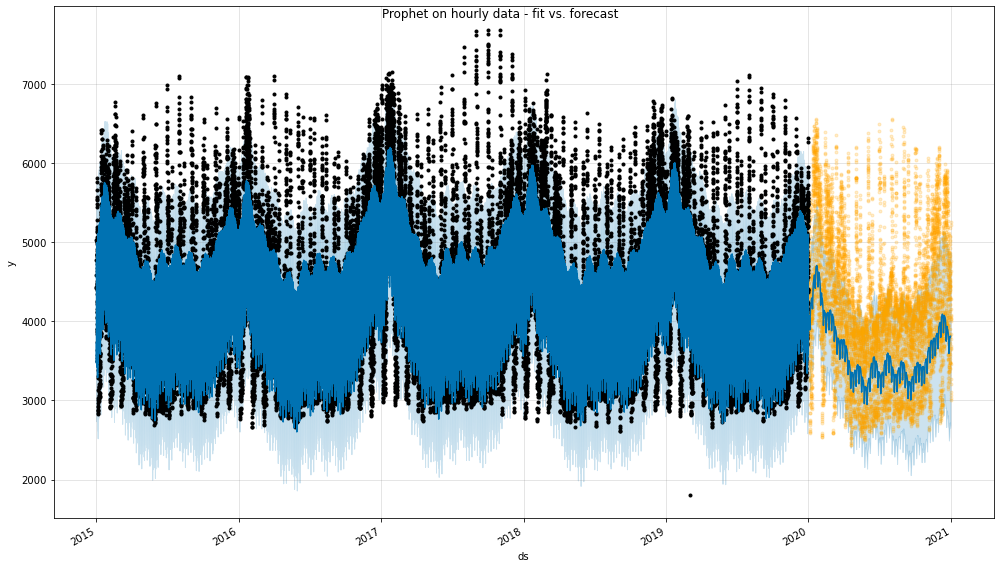

In [44]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.2)
m.plot(forecast, ax=ax)
plt.suptitle('Prophet on hourly data - fit vs. forecast')
plt.show()

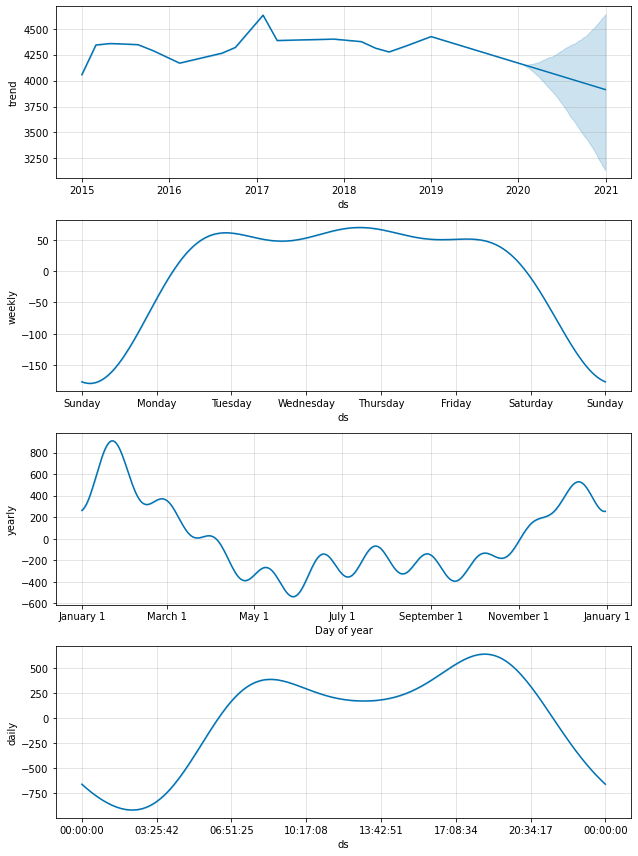

In [28]:
#Plot the breakdown of components
m.plot_components(forecast);

### Prophet with daily data

In [45]:
prophet_time_series = final_df.pipe(resample_as_needed).reset_index()
prophet_time_series = prophet_time_series.rename({'time':'ds', 'actuals':'y'}, axis=1)

train_set_prophet = prophet_time_series.loc[lambda df: df['ds'] < pd.to_datetime('2020-01-01')]
test_set_prophet = prophet_time_series.loc[lambda df: df['ds'] >= pd.to_datetime('2020-01-01')]

In [46]:
m = Prophet()
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


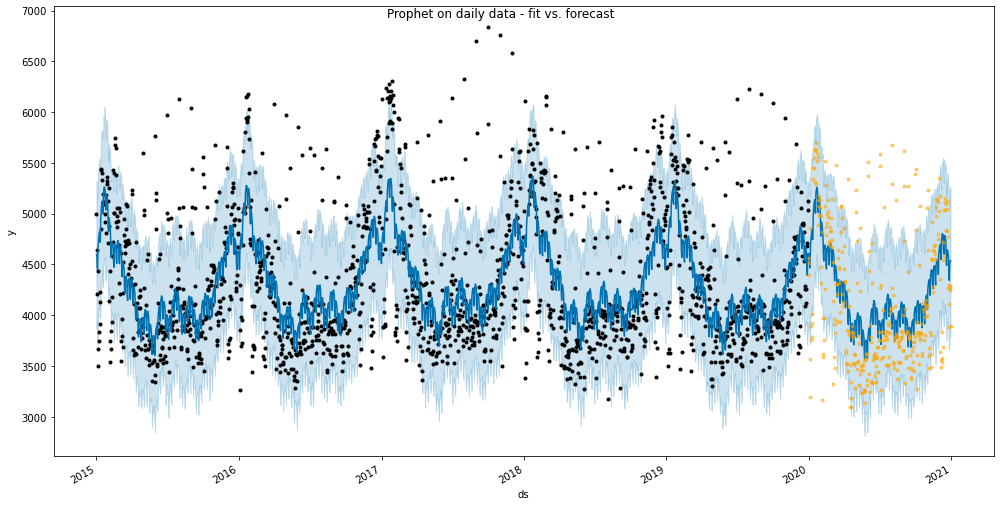

In [54]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data - fit vs. forecast')
plt.show()

#### Be careful with the plots out of the plot_components function - trends might seem steeper than they are. Always look for the y-axis to assess the actual impact.

In our case, the drop in trends is from a peak in 2017 of 4400 GGwats to forcast of ca. 4200 - less than 5% drop, but the plot makes it seem bigger.

The weekly seasonality is strong - with energy consumption dropping 150 points on Sundays. 
Even stronger is the yearly seasonality, with peaks in the winter months and a low point in June, before the cooling requirements peak.

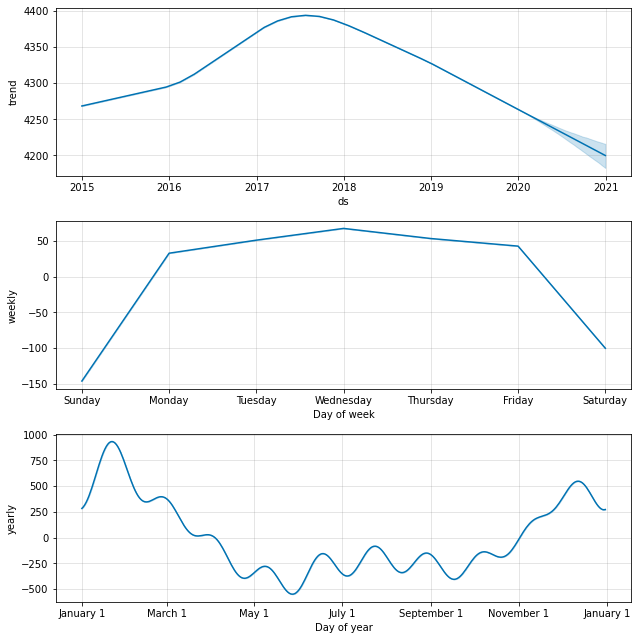

In [55]:
m.plot_components(forecast);

#### Prophet enables a very easy addition of holidays With holidays for Bulgaria and with increased sensitivity of the trend

In [57]:
m = Prophet()
m.add_country_holidays('BG')
m.fit(train_set_prophet)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


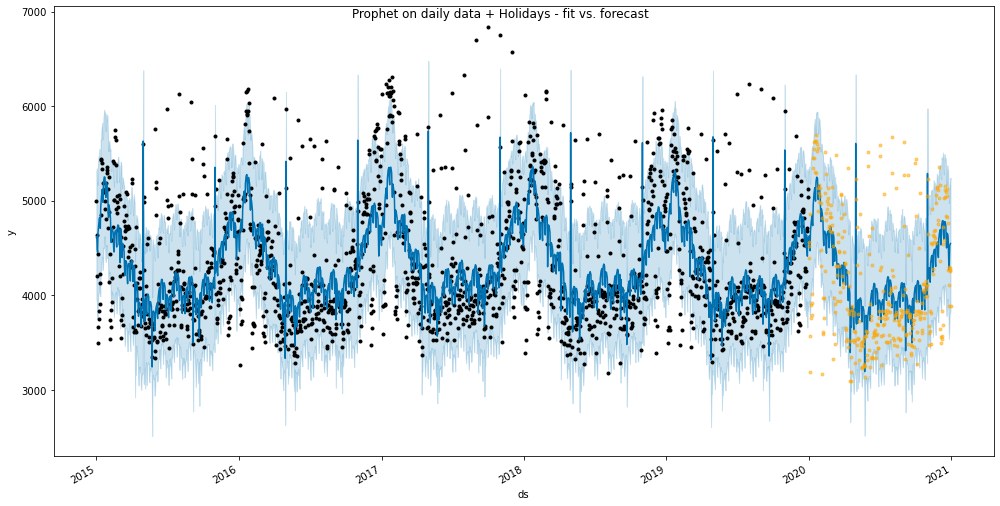

In [58]:
#Plot fit and forecast
fig, ax = plt.subplots(figsize=(14,8))
m.plot(forecast, ax=ax)
test_set_prophet.set_index('ds').y.plot(ax=ax, style = ".", color='orange', alpha=0.5)
plt.suptitle('Prophet on daily data + Holidays - fit vs. forecast')
plt.show()

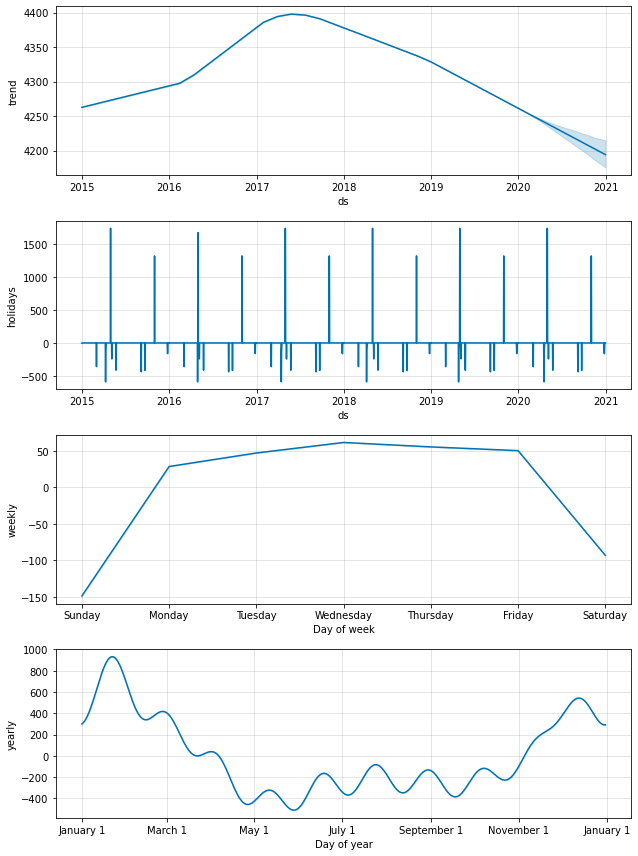

In [60]:
#Plot the breakdown of components - notice the strong holidays effect
m.plot_components(forecast);

<AxesSubplot:>

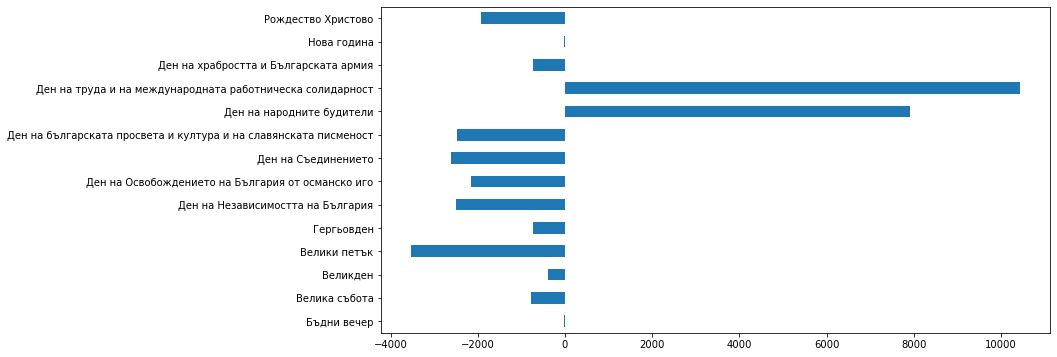

In [85]:
bg_holidays = forecast.columns[ 18:-4]
#Remove the upper and lower conf intervals
holidays_impact = [h for h in bg_holidays if ("_upper" not in h) and ('_lower' not in h)]

forecast.loc[:,holidays_impact].sum().plot.barh(figsize=(12,6))

In [82]:
forecast[holidays_impact].tail(10)

,Бъдни вечер,Велика събота,Великден,Велики петък,Гергьовден,Ден на Независимостта на България,Ден на Освобождението на България от османско иго,Ден на Съединението,Ден на българската просвета и култура и на славянската писменост,Ден на народните будители,Ден на труда и на международната работническа солидарност,Ден на храбростта и Българската армия,Нова година,Рождество Христово
2181,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2182,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2183,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2184,-3.846392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2185,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-159.783591
2186,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-159.783591
2187,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2188,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2189,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2190,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
